In [1]:
from keras.applications import DenseNet121
import keras.backend as K
from keras.layers import Input, AveragePooling1D, GlobalAveragePooling2D, Lambda
from keras.models import Model
from keras.preprocessing import image

import tensorflow as tf

from PIL import Image

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, train_test_split

from scipy.optimize import minimize

from matplotlib.pyplot import imshow

from itertools import islice
from pathlib import Path

Using TensorFlow backend.


In [2]:
config=tf.ConfigProto()
config.gpu_options.allow_growth=True
K.set_session(tf.Session(config=config))

In [3]:
data_dir = Path('..')/'data'

In [4]:
img_size = 256
img_channel = 3
img_dim = (img_size, img_size, img_channel)

In [5]:
def img_path(id, train=True):
    dataset = 'train' if train else 'test'
    return data_dir/f'{dataset}_images'/f'{id}-1.jpg'

In [6]:
def img_get_size(path, placeholder=0):
    try:
        img = image.load_img(path)
    except FileNotFoundError:
        return placeholder
    h, w = img.size
    return h * w

In [7]:
def img_resize_square(img, size=img_size):
    a, b = img.size
    long = a > b
    ratio = max(img.size) / size
    new_size = (size, int(b / ratio)) if long else (int(a / ratio), size)
    
    x, y = new_size
    paste = (0, (size - y) // 2) if long else ((size - x) // 2, 0)
    
    resized = img.resize(new_size, Image.ANTIALIAS)
    resized_pad = Image.new('RGB', (size, size))
    resized_pad.paste(resized, paste)
    
    return image.img_to_array(resized_pad)

In [8]:
def img_process(path, placeholder=np.zeros(img_dim)):
    try:
        return img_resize_square(image.load_img(path))
    except FileNotFoundError:
        return placeholder

In [9]:
def show_arr(arr):
    imshow(arr.astype(int))

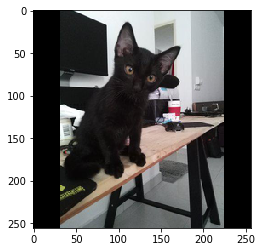

In [10]:
show_arr(img_process(img_path('86e1089a3')))

In [11]:
inputs = Input(img_dim)

In [12]:
base_layer = DenseNet121(input_tensor=inputs, weights='imagenet', include_top=False) 

In [13]:
layer = base_layer.output
layer = GlobalAveragePooling2D()(layer)
layer = Lambda(K.expand_dims)(layer)
layer = AveragePooling1D(4)(layer)
outputs = Lambda(lambda x: x[:, :, 0])(layer)

In [14]:
model = Model(inputs, outputs)

In [15]:
df = pd.read_csv(data_dir/'train.csv')
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [16]:
batch_size = 32

In [17]:
def img_generator(paths, batch_size=batch_size):
    images = (img_process(path) for path in paths)
    while True:
        try:
            yield np.stack(tuple(islice(images, batch_size)))
        except ValueError:
            raise StopIteration

In [18]:
train_img_paths = [img_path(id) for id in df.PetID]
img_features = model.predict_generator(img_generator(train_img_paths), steps=np.ceil(df.shape[0] / batch_size))

In [19]:
K.clear_session()

In [20]:
img_features_df = pd.DataFrame(img_features, columns=(f'img_feature_{i}' for i in range(img_features.shape[1])))
img_features_df.shape

(14993, 256)

In [21]:
img_sizes = np.asarray([img_get_size(path) for path in train_img_paths])

In [22]:
df = pd.concat([df, img_features_df], axis=1, sort=False)
df['img_size'] = img_sizes
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,img_feature_247,img_feature_248,img_feature_249,img_feature_250,img_feature_251,img_feature_252,img_feature_253,img_feature_254,img_feature_255,img_size
0,2,Nibble,3,299,0,1,1,7,0,1,...,6.497355,1.071009,0.864625,1.608018,1.047267,2.674465,0.606289,1.191459,2.390231,172800
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,4.631561,3.283723,5.725550,0.510215,3.971013,1.144544,1.396197,2.877835,5.802525,150423
2,1,Brisco,1,307,0,1,2,7,0,2,...,4.583096,4.648917,1.586716,2.512184,2.158268,4.725864,2.934669,1.983264,6.348276,120000
3,1,Miko,4,307,0,2,1,2,0,2,...,6.001115,0.742916,0.754055,2.621660,0.686731,1.302038,0.304580,0.894532,2.598722,120000
4,1,Hunter,1,307,0,1,1,0,0,2,...,4.337534,2.804142,0.737020,1.967237,0.674463,1.620374,2.222703,1.146679,3.298575,273280


In [23]:
image_feature_columns = [col for col in df if col.startswith('img_feature_')]

In [24]:
import json

In [25]:
def sentiment_path(id, train=True):
    dataset = 'train' if train else 'test'
    return data_dir/f'{dataset}_sentiment'/f'{id}.json'

In [26]:
prototype = {
    'document_sentiment_magnitude': 0,
    'document_sentiment_score': 0,
    'sentiment_magnitude_mean': 0,
    'sentiment_magnitude_max': 0,
    'sentiment_magnitude_sd': 0,
    'sentiment_score_mean': 0,
    'sentiment_score_max': 0,
    'sentiment_score_sd': 0,
}

In [27]:
sentiment_features = prototype.keys()
sentiment_features

dict_keys(['document_sentiment_magnitude', 'document_sentiment_score', 'sentiment_magnitude_mean', 'sentiment_magnitude_max', 'sentiment_magnitude_sd', 'sentiment_score_mean', 'sentiment_score_max', 'sentiment_score_sd'])

In [28]:
def sentiment(path, placeholder=None):
    placeholder = prototype.copy() if placeholder is None else placeholder
    
    try:
        with open(path) as f:
            content = json.load(f)
    except FileNotFoundError:
        return placeholder.copy()
    
    scores = np.asarray(
        [sentence['sentiment']['score'] for sentence in content['sentences']]
    )
    magnitudes = np.asarray(
        [sentence['sentiment']['magnitude'] for sentence in content['sentences']]
    )
    result = {
        'document_sentiment_magnitude': content['documentSentiment']['magnitude'],
        'document_sentiment_score': content['documentSentiment']['score'],
        'sentiment_magnitude_mean': magnitudes.mean(),
        'sentiment_magnitude_max': magnitudes.max(),
        'sentiment_magnitude_sd': magnitudes.std(),
        'sentiment_score_mean': scores.mean(),
        'sentiment_score_max': scores.max(),
        'sentiment_score_sd': scores.std(),
    }
    return result

In [29]:
train_sentiment_paths = (sentiment_path(id) for id in df.PetID)
sentiments = (sentiment(path) for path in train_sentiment_paths)

In [30]:
sentiment_df = pd.DataFrame(data=sentiments)
sentiment_df.head()

,document_sentiment_magnitude,document_sentiment_score,sentiment_magnitude_max,sentiment_magnitude_mean,sentiment_magnitude_sd,sentiment_score_max,sentiment_score_mean,sentiment_score_sd
0,2.4,0.3,0.8,0.366667,0.319722,0.8,0.300000,0.382971
1,0.7,-0.2,0.6,0.350000,0.250000,0.1,-0.250000,0.350000
2,3.7,0.2,0.9,0.485714,0.352252,0.9,0.200000,0.565685
3,0.9,0.9,0.9,0.900000,0.000000,0.9,0.900000,0.000000
4,3.7,0.6,0.8,0.583333,0.267187,0.8,0.583333,0.267187


In [31]:
df = pd.concat([df, sentiment_df], axis=1, sort=False)
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,img_feature_255,img_size,document_sentiment_magnitude,document_sentiment_score,sentiment_magnitude_max,sentiment_magnitude_mean,sentiment_magnitude_sd,sentiment_score_max,sentiment_score_mean,sentiment_score_sd
0,2,Nibble,3,299,0,1,1,7,0,1,...,2.390231,172800,2.4,0.3,0.8,0.366667,0.319722,0.8,0.300000,0.382971
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,5.802525,150423,0.7,-0.2,0.6,0.350000,0.250000,0.1,-0.250000,0.350000
2,1,Brisco,1,307,0,1,2,7,0,2,...,6.348276,120000,3.7,0.2,0.9,0.485714,0.352252,0.9,0.200000,0.565685
3,1,Miko,4,307,0,2,1,2,0,2,...,2.598722,120000,0.9,0.9,0.9,0.900000,0.000000,0.9,0.900000,0.000000
4,1,Hunter,1,307,0,1,1,0,0,2,...,3.298575,273280,3.7,0.6,0.8,0.583333,0.267187,0.8,0.583333,0.267187


In [32]:
from nltk.corpus import stopwords

import string

In [33]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = (char for char in mess if char not in string.punctuation)

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc).lower()
    
    # Now just remove any stopwords
    return ' '.join(word for word in nopunc.split() if word not in stopwords.words('english'))

In [34]:
def prepare(df):
    
    rescuer_count = df.groupby(['RescuerID'])['PetID'].count().reset_index()
    rescuer_count.columns = ['RescuerID', 'RescuerID_count']
    df = df.merge(rescuer_count, how='left', on='RescuerID')
    
    df = df.copy(deep=True)
    df.Description = np.asarray([text_process(text) for text in df.Description.astype(str)])
    df['pure_breed'] = np.where(df.Breed2 == 0, 1, 0)
    df['pure_color'] = np.where(df.Color2 == 0, 1, 0)
    df.Type = df.Type - 1
    df.Vaccinated = np.where(df.Vaccinated == 1, 1, 0)
    df.Dewormed = np.where(df.Dewormed == 1, 1, 0)
    df.Sterilized = np.where(df.Sterilized == 1, 1, 0)
    df.MaturitySize = np.where(df.MaturitySize == 0, np.nan, df.MaturitySize).astype(int)
    df.FurLength = np.where(df.FurLength == 0, np.nan, df.FurLength).astype(int)
    df.Health = np.where(df.Health == 0, np.nan, df.Health).astype(int)
    df.Gender = np.where(df.Gender == 3, 0, df.Gender)
    df.Color1 = np.where(df.Color1 == 7, 0, df.Color1)
    genders = pd.get_dummies(df.Gender, prefix='Gender', drop_first=True)
    colors = pd.get_dummies(df.Color1, prefix='Color', drop_first=True)
    df = pd.concat([df, genders, colors], axis=1)
    features = [
        'Type', 'Age', 'pure_breed', 'pure_color',
        'MaturitySize', 'FurLength', 'Health',
        'Vaccinated', 'Dewormed', 'Sterilized',
        'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt',
        'Description',
        'RescuerID_count',
        'Breed1', 'Breed2', 'State',
        *sentiment_features,
        'img_size',
        *[col for col in df if col.startswith('Gender_')],
        *[col for col in df if col.startswith('Color_')],
        *image_feature_columns
    ]
    df = df[features]
    return df

In [35]:
data = prepare(df)

In [36]:
random_state = 3578

In [37]:
features_df, test_df, y_train, y_test = train_test_split(data, df.AdoptionSpeed, test_size=0.2,
                                                         random_state=random_state)
features_df.head()

,Type,Age,pure_breed,pure_color,MaturitySize,FurLength,Health,Vaccinated,Dewormed,Sterilized,...,img_feature_246,img_feature_247,img_feature_248,img_feature_249,img_feature_250,img_feature_251,img_feature_252,img_feature_253,img_feature_254,img_feature_255
1016,1,18,1,0,2,2,1,0,0,0,...,3.560894,3.969728,0.758167,0.207285,2.155571,1.028503,1.621518,0.407048,2.029758,1.601749
1127,0,4,0,0,2,1,1,1,1,0,...,3.153351,2.494447,3.721642,1.166776,1.056834,0.649548,3.368789,3.414960,1.148465,4.639685
4693,0,1,1,1,2,1,1,0,0,0,...,5.175702,4.197392,5.980432,2.502997,3.338583,3.208372,7.212343,4.282681,3.391648,10.322552
14000,0,2,1,0,2,1,1,0,0,0,...,5.456614,5.838250,2.755549,2.081964,2.131108,1.558811,5.026907,1.703490,1.983083,4.833841
5082,0,3,1,0,2,3,1,0,1,0,...,3.953401,2.251080,4.026611,0.996144,2.565880,0.771531,2.958395,2.935195,1.661222,4.676108


In [38]:
split_dir = data_dir/'split'

In [39]:
features_df.to_csv(split_dir/'x_train.csv', index=False)
test_df.to_csv(split_dir/'x_test.csv', index=False)
y_train.to_csv(split_dir/'y_train.csv', index=False)
y_test.to_csv(split_dir/'y_test.csv', index=False)

/home/kien/.pyenv/versions/miniconda3-4.3.30/envs/petfinder/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kien/.pyenv/versions/miniconda3-4.3.30/envs/petfinder/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

In [41]:
class XGBOrdinalClassifier(xgb.XGBRegressor):
    def _predict_cut(self, y, cuts):
        return pd.cut(y, [-np.Inf, *sorted(cuts), np.Inf], labels=[0, 1, 2, 3, 4])
        
    def _objective(self, y_pred, y, cuts):
        preds = self._predict_cut(y_pred, cuts)
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        
        inits = [0.5, 1.5, 2.5, 3.5]
        raw = super().predict(X)
        results = minimize(lambda cuts: self._objective(raw, y, cuts), inits, method='Nelder-Mead')
        self._cuts = results.x
        
        return self
    
    def predict(self, X, **kwargs):
        raw = super().predict(X, **kwargs)
        
        return self._predict_cut(raw, self._cuts)

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
class XGBOrdinalClassifierAccuracy(xgb.XGBRegressor):
    def _predict_cut(self, y, cuts):
        return pd.cut(y, [-np.Inf, *sorted(cuts), np.Inf], labels=[0, 1, 2, 3, 4])
        
    def _objective(self, y_pred, y, cuts):
        preds = self._predict_cut(y_pred, cuts)
        return -accuracy_score(y, preds)
    
    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        
        inits = [0.5, 1.5, 2.5, 3.5]
        raw = super().predict(X)
        results = minimize(lambda cuts: self._objective(raw, y, cuts), inits, method='Nelder-Mead')
        self._cuts = results.x
        
        return self
    
    def predict(self, X, **kwargs):
        raw = super().predict(X, **kwargs)
        
        return self._predict_cut(raw, self._cuts)

In [44]:
text_svd_ncomp = 32
img_svd_ncomp = 255

In [45]:
text_preprocessor = Pipeline(steps=[
    ('count_vector', CountVectorizer(analyzer='word')),
    ('tf_idf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=text_svd_ncomp, random_state=random_state))
])

In [46]:
image_preprocessor = FeatureUnion([
    ('original', FunctionTransformer(validate=False)),
#     ('svd', TruncatedSVD(n_components=img_svd_ncomp, random_state=random_state))
])

In [47]:
preprocessor = ColumnTransformer(transformers=[
    ('text', text_preprocessor, 'Description'),
    ('image', image_preprocessor, image_feature_columns),
#     ('drop', 'drop', list(sentiment_features)),
#     ('drop', 'drop', ['Breed1', 'Breed2', 'State'])
], remainder='passthrough')

In [48]:
# TODO: genetic algorithm
params = {
    'eval_metric': 'rmse',
    'seed': 1200,
    'tree_method': 'gpu_hist',
    'device': 'gpu',
}

params_tune = {
    'predict__subsample': [0.8],
    'predict__colsample_bytree': [0.85],
}

In [49]:
# predictor = xgb.XGBClassifier()
predictor = XGBOrdinalClassifierAccuracy(**params)

In [50]:
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('predict', predictor)
])

In [51]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, GridSearchCV

from utils import cohen_kappa_scorer
# cohen_kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

In [52]:
CV = GridSearchCV(pipeline, param_grid=params_tune,
                  cv=15, scoring='accuracy',
                  refit=True, n_jobs=10)

In [53]:
cvs = CV.fit(features_df, y_train)

In [54]:
cvs.best_score_

0.3918625979656495

In [55]:
cvs.best_estimator_

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('text', Pipeline(memory=None,
     steps=[('count_vector', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtyp... scale_pos_weight=1, seed=1200, silent=True,
               subsample=0.8, tree_method='gpu_hist'))])

In [56]:
model = cvs.best_estimator_.fit(features_df, y_train)
pred = model.predict(test_df)
accuracy_score(y_test, pred)

0.3924641547182394

In [57]:
cohen_kappa_score(y_test, pred, weights='quadratic')

0.37847606095851793